# Trabajo Final de Inferencia Bayesiana

## Resumen

En este trabajo se intenta desarrollar un modelo bayesiano que permita inferir cambios emocionales básicos a partir de datos fisiológicos. El sistema nervioso simpatico es un sistema autónomo del ser humano que cumple entre otros papeles el de preparar al cuerpo para situaciones de acción, la clásica reacción de *fight or flight*. Cuando este sistema detecta una situación peligrosa envía señales a distintas partes del cuerpo, entre otras las glandulas sudoripadas, el corazón y los músculos del aparato locomotor. Realizando un modelo forward intentaremos modelar esta situación de relajación en la que el sistema simpatico no esta activo versus el momento en que detecta una amenaza, una vez logrado esto aplicaremos inferencia bayesiana para detectar dado un conjunto de mediciones fisiológicas estos momentos de alerta.

## Los Datos
Los datos fueron tomados con el *activity tracker* Microsoft Band 2, este posee varios sensores entre ellos los que nos serán de interés serán la temperatura corporal, la conductancia cutanea y los pulsos por minuto, debido a que estos son los que mayor respuesta tienen ante la activación del sistema simpático, la conductancia cutanea cambia dependiendo el nivel de sudoración.

<img src="mband.jpg" width="300" height="300" />

En el caso particular que veremos en este informe se detalla el caso de un sujeto el cual fue sensado mientras veia un video de 5 minutos de una escena de suspenso y terror. Como es de esperarse se nota un cambio en la respuesta fisiologica el cual parece indicar un cambio de un estado de relajación a uno de mayor alerta y tensión.

In [5]:
import csv
import os

def loadData(files):
    grs = []
    temps = []
    bpms = []
    for file in files:
        with open("Data/" + file) as data:
            gr = []
            temp = []
            bpm = []
            spamreader = csv.reader(data, delimiter=',', quotechar='|')
            for row in spamreader:
                gr.append(float(row[0]))
                temp.append(float(row[1]))
                bpm.append(float(row[2]))
            grs.append(gr)
            temps.append(temp)
            bpms.append(bpm)
            labels.append(file)
    return grs, temps, bpms

files = ["eugeExcitacion1.txt"]
grs, temps, bpms = loadData(files)

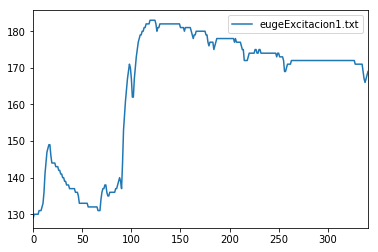

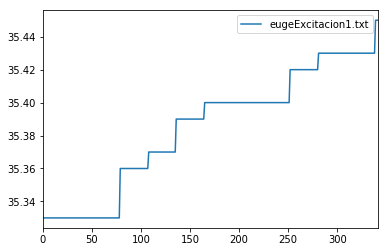

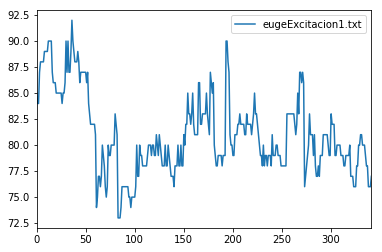

In [6]:
import pandas as pd

def toPlotableVector(signals):
    res = []
    for signal in signals:
        for i in range(len(signal)):
            if i > len(res) - 1:
                res.append([signal[i]])
            else:
                res[i].append(signal[i])
    return res

df1 = pd.DataFrame(toPlotableVector(grs))
df2 = pd.DataFrame(toPlotableVector(temps))
df3 = pd.DataFrame(toPlotableVector(bpms))
df1.columns = files
df2.columns = files
df3.columns = files

%matplotlib inline
df1.plot()
df2.plot()
df3.plot()

## El Modelo

Aqui se modela como ante un estimulo se pasaPor simplicidad el modelo asume que hay un solo cambio de estado, la variable uniforme tau, es la que representa este momento. 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_interval__]
>Metropolis: [tau]
>Metropolis: [meanTemp2_interval__]
>Metropolis: [meanTemp1_interval__]
>Metropolis: [meanGr2_interval__]
>Metropolis: [meanGr1_interval__]
>Metropolis: [meanBpm2_interval__]
>Metropolis: [meanBpm1_interval__]
100%|██████████| 10500/10500 [00:17<00:00, 614.17it/s]
The number of effective samples is smaller than 25% for some parameters.


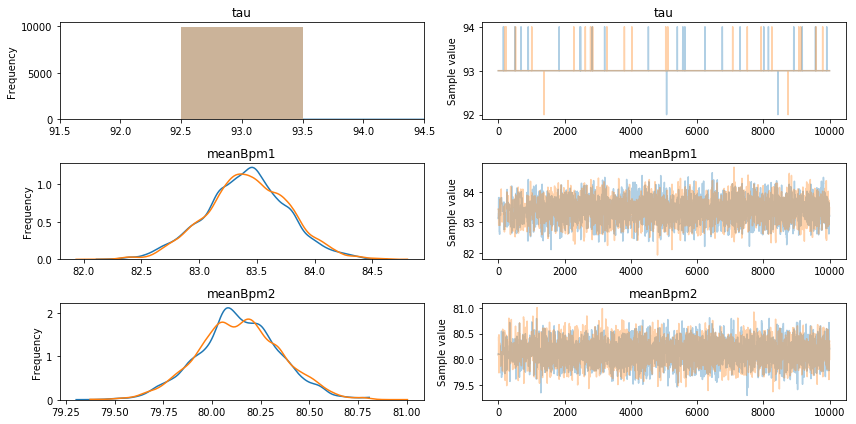

In [7]:
import pymc3 as pm, theano.tensor as tt
import numpy as np

exp_index = 0

n_samples = len(bpms[exp_index])-1
model = pm.Model()

with model:
    meanBpm1 = pm.Uniform('meanBpm1', lower=0, upper=200)
    meanBpm2 = pm.Uniform('meanBpm2', lower=0, upper=200)
    meanGr1 = pm.Uniform('meanGr1', lower=0, upper=5000)
    meanGr2 = pm.Uniform('meanGr2', lower=0, upper=5000)
    meanTemp1 = pm.Uniform('meanTemp1', lower=0, upper=45)
    meanTemp2 = pm.Uniform('meanTemp2', lower=0, upper=45)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_samples)
    
    idx = np.arange(n_samples+1)
    meanBpm = pm.math.switch(tau > idx, meanBpm1, meanBpm2)
    meanGr = pm.math.switch(tau > idx, meanGr1, meanGr2)
    meanTemp = pm.math.switch(tau > idx, meanTemp1, meanTemp2)

    sd = pm.Uniform('sd', lower=0, upper=20)

    points1 = pm.Normal('bpm',
                       mu=meanBpm,
                       sd=sd,
                       observed=bpms[exp_index])

    points1 = pm.Normal('gr',
                       mu=meanGr,
                       sd=sd,
                       observed=grs[exp_index])

    points1 = pm.Normal('Temp',
                       mu=meanTemp,
                       sd=sd,
                       observed=temps[exp_index])

# fit model
with model:
    step = pm.Metropolis()
    tr = pm.sample(10000, step=step)
    
pm.plots.traceplot(tr, ['tau', 'meanBpm1', 'meanBpm2']);